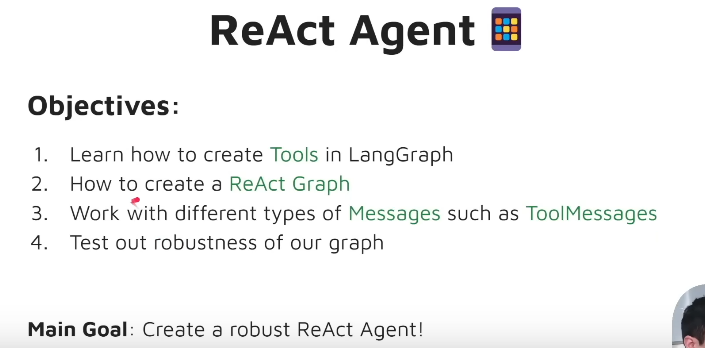

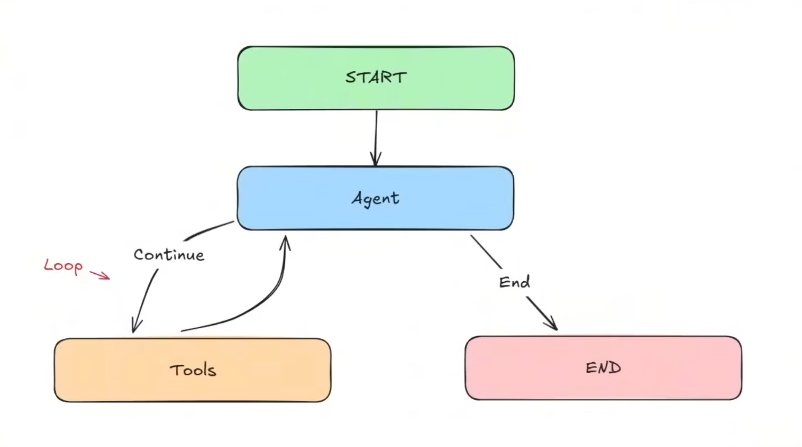

### What is Annotated type?
It provides additional context without affecting the type itself

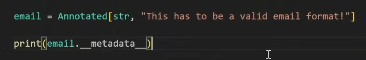
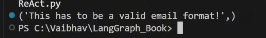

### What is Sequence type?
It automatically handles the state updates for sequences such as adding new messages to a chat history

It is used to avoid unecessary list manipulations and have that handles

In [1]:
from typing import TypedDict, Annotated, Sequence
from dotenv import load_dotenv
from langchain_core.messages import BaseMessage # the foundational class for all message types in langgraph
from langchain_core.messages import ToolMessage # passes data back to LLM after it calls a tool, such as the content and the tool_call_id
from langchain_core.messages import SystemMessage # message for providing instructions to the LLM
from langchain_openai import ChatOpenAI
from langchain_core.tools import tool
from langgraph.graph.message import add_messages
from langgraph.graph import StateGraph, END
from langgraph.prebuilt import ToolNode


load_dotenv()

True

### What is add_messages?
- It is a reducer function
- It is a rule that controls how new updates from nodes are combined with the existig state
- Tells us how to merge new data ito the current state
- Without the reducer, updates would have replaced the existing value entirely!

- We use a reducer because we dont wanna fuck with .append anymore, it is not efficient with so many messages going around

In [2]:
class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], add_messages]

Create and add tools:
( the doc string is literally necessary here or it will give error)

In [3]:
@tool
def add(a: int, b: int):
    """ This is an addition function that adds 2 numbers together """
    return a + b

@tool
def subtract(a: int, b: int):
    """ Subtraction function """
    return a - b

@tool
def multiply(a: int, b: int):
    """ Multiplication function """
    return a * b

tools = [add, subtract, multiply]

model = ChatOpenAI(model = "gpt-4o").bind_tools(tools)


Because add_messages handles updating of our messages for us now, we can just return {"messages": [New Value]} instead of manuaally appending them.

Intake the state, then return the new value in the form of state to update it

In [4]:
def model_call(state: AgentState)  -> AgentState:
    system_prompt = SystemMessage(content="You are my AI assistant, please answer my query to the best of your ability.")
    response = model.invoke([system_prompt] + state["messages"])

    return {"messages": [response]}

In [5]:
def should_continue(state: AgentState):
    messages = state["messages"]
    last_message = messages[-1]
    if not last_message.tool_calls:
        return "end"
    else: 
        return "continue"

In [8]:
graph = StateGraph(AgentState)
graph.add_node("our_agent", model_call)

tool_node = ToolNode(tools=tools)
graph.add_node("tools", tool_node)

graph.set_entry_point("our_agent")

graph.add_conditional_edges(
    "our_agent",
    should_continue,
    {
        "continue": "tools",
        "end": END
    }
)

graph.add_edge("tools", "our_agent")

app = graph.compile()

def print_stream(stream):
    for s in stream:
        message = s["messages"][-1]
        if isinstance(message, tuple):
            print(message)
        else:
            message.pretty_print()

inputs = {"messages": [("user", "Add 40  + 12 and then multiply the result by 6, also tell me a joke please")]}
print_stream(app.stream(inputs, stream_mode="values"))

================================ Human Message =================================

Add 40  + 12 and then multiply the result by 6, also tell me a joke please
================================== Ai Message ==================================
Tool Calls:
  add (call_a3dZsIkJauLt4PSjPHgyiSW8)
 Call ID: call_a3dZsIkJauLt4PSjPHgyiSW8
  Args:
    a: 40
    b: 12
  multiply (call_UHrelwahlddBYl64D4V7qfN5)
 Call ID: call_UHrelwahlddBYl64D4V7qfN5
  Args:
    a: 52
    b: 6
================================= Tool Message =================================
Name: multiply

312
================================== Ai Message ==================================

The sum of 40 and 12 is 52, and multiplying that result by 6 gives us 312.

And here's a joke for you:

Why don't scientists trust atoms?

Because they make up everything!


LLM is the one deciding which arguments to pass to the tool function, and which tools to use.